# **추천 시스템 기술 서베이**

## **라이브러리 설치 및 보일러플레이팅**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'ML/OSAM/'

%cd drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/My Drive/ML/OSAM


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.8 MB 8.7 MB/s 
     |████████████████████████████████| 895 kB 55.9 MB/s 
     |████████████████████████████████| 636 kB 72.4 MB/s 
     |████████████████████████████████| 52 kB 2.0 MB/s 
     |████████████████████████████████| 3.3 MB 52.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import tensorflow as tf
import tensorflow.keras as k
import transformers as t
import numpy as np
import pandas as pd
import pickle
import tqdm

## **데이터 로딩**

[Wikilingua](https://github.com/esdurmus/Wikilingua) 의 한국어 [데이터셋](https://drive.google.com/drive/folders/1PFvXUOsW_KSEzFm5ixB8J8BDB8zRRfHW)을 사용 (총 4,111개의 주제, 12,176개의 문단)

In [ ]:
with open('korean.pkl', 'rb') as f:
    data = pickle.load(f)

lengths = [ len(item.keys()) for key, item in data.items() ]
print(f'total {len(data.keys())} chunks, {sum(lengths)} paragraphs loaded')
list(data.items())[0]

total 4111 chunks, 12176 paragraphs loaded


('https://ko.wikihow.com/%EC%83%81%EC%9E%90%EC%97%90-%EB%A6%AC%EB%B3%B8-%EB%AC%B6%EB%8A%94-%EB%B0%A9%EB%B2%95',
 {'기본으로 묶기': {'document': '10.16 - 20.32cm 정도는 밖으로 나오게 남겨둔다. 끈 끝이 너무 짧은 것보다 남겨놓는 게 더 좋다. 나중에 짧게 자를 수 있다. 상자를 뒤집지 않는다. 그러면 놓칠 수 있다. 대신에 상자를 들어서 끈을 뒤로 넣는다. 끈이 반대쪽으로 나오면 상자를 내려놓는다. 상자 중간으로 끈을 가져온 다음에 더 짧은 부분을 가져와서 만나게 한다. 끈을 서로 엮어서 수직으로 맞춘다. 끈 앞뒤가 다르다면 두 번 꼬아서 끈 뒤가 안 보이게 만든다. 다시 상자를 들어 올린다. 상자 뒤에 있는 끈의 긴 부분을 반대쪽으로 당긴다. 다시 상자를 내려놓는다. 끈으로 뒤를 감쌀 때는 끈을 엮은 부분에 엄지로 눌러 고정한다. 상자 중간으로 끈을 가져온다. 끈의 시작과 끝부분을 잰 뒤 자른다. 꼬인 부분의 앞쪽에 있는 끈을 비스듬히 당긴다. 끈을 꼬인 부분 밑으로 가져와서 처음에 시작했던 곳으로 다시 뺀다. 끈의 양 끝을 잡아당겨 매듭을 짓는다. 끈 양 끝을 접어서 고리로 만든다. 왼쪽 고리를 오른쪽 고리에 넣어 중간에 더 작은 고리를 만든다. 왼쪽 고리를 더 작은 고리 안으로 당긴 다음 조인다. 고리와 끝부분을 조절한다. 철사 끈을 사용했다면, 고리를 풍성하게 만들어준다. 더 멋지게 꾸미고 싶다면 끈 양 끝을 각지게 자르거나 V 모양으로 자른다.',
   'english_section_name': 'Doing a Basic Wrap',
   'english_url': 'https://www.wikihow.com/Tie-a-Ribbon-Around-a-Box',
   'summary': '상자 위에 끈을 수평으로 놓기. 끈 나머지를 상자 밑으로 넣고 다시 앞으로 당기기. 상자 앞으로 끈을 가져오기. 끈으로 상자 뒤를 감싸고 앞으로 가져오기.

In [ ]:
from urllib import parse

titles, subtitles, english_section_names, english_urls, documents, summaries = [], [], [], [], [], []

for url, chunk in data.items():
    title = parse.unquote(url.split('/')[-1]).replace('-', ' ')
    for subtitle, page in chunk.items():
        titles.append(title)
        subtitles.append(subtitle)
        english_section_names.append(page['english_section_name'])
        english_urls.append(page['english_url'])
        documents.append(page['document'])
        summaries.append(page['summary'])

df = pd.DataFrame({
    'title': titles,
    'subtitle': subtitles,
    'english_section_name': english_section_names,
    'english_url' : english_urls,
    'document': documents,
    'summary': summaries
})
df.head()

,title,subtitle,english_section_name,english_url,document,summary
0,상자에 리본 묶는 방법,대각선으로 묶기,Tying Ribbon Diagonally,https://www.wikihow.com/Tie-a-Ribbon-Around-a-Box,왼쪽 상단 구석에 10.16 - 20.32cm 정도의 끈을 남긴다. 끈 나머지 부분...,상자 왼쪽 상단 구석에 끈을 두르기. 오른쪽 상단 구석에 끈을 두르기. 끈으로 오른...
1,상자에 리본 묶는 방법,기본으로 묶기,Doing a Basic Wrap,https://www.wikihow.com/Tie-a-Ribbon-Around-a-Box,10.16 - 20.32cm 정도는 밖으로 나오게 남겨둔다. 끈 끝이 너무 짧은 것...,상자 위에 끈을 수평으로 놓기. 끈 나머지를 상자 밑으로 넣고 다시 앞으로 당기기....
2,상자에 리본 묶는 방법,엮어 묶기,Creating a Woven Look,https://www.wikihow.com/Tie-a-Ribbon-Around-a-Box,끈을 상자 길이에 5.08cm를 더한 길이로 네 개를 잘라야 한다. 색다른 느낌을...,상자 길이에 맞게 끈을 자르기. 끈을 상자 넓이에 맞게 자르기. 처음 자른 끈을 탁...
3,집에서 아이스크림 만드는 법,커스터드 아이스크림 베이스 준비하기,Preparing a Custard Ice Cream Base,https://www.wikihow.com/Make-Ice-Cream,"전유를 중간 사이즈 냄비에 3컵 (700 ml)을 부어주고, 냄비를 가스레인지 위에...",우유를 약하게 끓이기. 30분 동안 혼합물을 식혀주기.
4,집에서 아이스크림 만드는 법,손으로 아이스크림 휘젓기,Churning the Ice Cream By Hand,https://www.wikihow.com/Make-Ice-Cream,냉동해도 안전한 얇은 팬이나 그릇을 사용한다. 베이스를 만들어주기 전에 냉동 용기를...,냉동 용기를 얼리기. 약 2시간 동안 얼리기와 휘젓기의 과정을 반복하기.


In [ ]:
df.document[0], df.summary[0]

('왼쪽 상단 구석에 10.16 - 20.32cm 정도의 끈을 남긴다. 끈 나머지 부분은 위 가장자리를 감싼다. 감싼 쪽 끈을 잡아서 오른쪽 상단 구석으로 당기고, 오른쪽 하단 구석으로 당긴다. 왼쪽 상단에 잇는 끈은 엄지로 계속 눌러서 고정한다. 끈을 딱 맞게 둘러야 끈이 옆으로 흐르지 않는다. 이쯤에서 각 모퉁이에 감싼 끈을 조절하면 좋다. 풀릴 것 같다면 모퉁이와 떨어뜨려 당겨준다. 끈 양쪽을 왼쪽 상단 모퉁이에 가져온다. 한쪽을 다른 쪽 끈에 대고 길이에 맞춰 자른다. 왼쪽 끈 위에 넣고 오른쪽 아래로 댕겨서 묶어서 조여준다. 두 끈으로 고리를 만든 다음, 오른쪽을 왼쪽으로 교차시킨다. 마치 신발을 묶듯이 말이다. 리본이 고정되게 만들었다면, 끝부분에 남은 끈을 자른다. 좀 저 멋지게 만들고 싶다면, 끝부분을 각지어 자르거나 V자로 자른다.',
 '상자 왼쪽 상단 구석에 끈을 두르기. 오른쪽 상단 구석에 끈을 두르기. 끈으로 오른쪽 하단 구석과 왼쪽 구석을 감싸기. 끈을 왼쪽 상단 구석으로 다시 가져오기. 남은 끈 자르기. 끈을 교차 시켜 묶기. 남은 끈 자르기.')

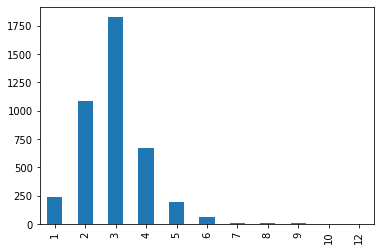

In [ ]:
# 한 제목 당 글타래 개수

df.groupby('title').size().value_counts().sort_index().plot(kind='bar')

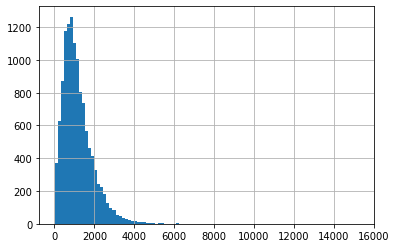

In [ ]:
# 글타래 길이의 분포
df['document'].map(lambda s: len(s)).hist(bins=100)

## **KcBERT 테스트**

In [ ]:
pretrained_name = 'beomi/kcbert-base'

tokenizer = t.BertTokenizer.from_pretrained(pretrained_name)

model = t.TFBertModel.from_pretrained(pretrained_name, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [ ]:
# conducts BERT embedding by batch

import math

def batch_embed(batch_sentences, use_summary=False):

    tokenized = tokenizer(batch_sentences, 
                        padding='max_length', 
                        truncation=True, 
                        max_length=300, 
                        return_tensors='tf')
    input_ids = tokenized['input_ids']
    input_mask = tf.cast(tokenized['attention_mask'], 'float32')

    embedding = model(input_ids=input_ids)['last_hidden_state']

    # using CLS token embedding
    if use_summary:
        final_embedding = embedding[:, 0, :]

    else:
        embedding_masked = tf.expand_dims(input_mask, -1) * embedding
        final_embedding = tf.reduce_sum(embedding_masked, axis=1) / tf.reduce_sum(input_mask, axis=-1, keepdims=True)
    
    return final_embedding

def embed(sentences, batch_size=100, use_summary=False):
    
    embedding_list = []

    for i in tqdm.tqdm(range( math.ceil( len(sentences) / batch_size ) )):
        start_idx = i * batch_size
        batch = sentences[ start_idx : start_idx + batch_size ].tolist()
        embedding_list.append( batch_embed(batch, use_summary=use_summary) )
    
    return tf.concat(embedding_list, 0)

embedded_document = embed(df.document)
np.save('embed_document_avg', embedded_document.numpy())

In [ ]:
embedded_document = tf.constant(np.load('embed_document_avg.npy'))

효율적인 NN(Nearest Neighbors) 알고리즘이 구현된 [annoy](https://github.com/spotify/annoy) 패키지를 사용

In [ ]:
!pip install annoy

     |████████████████████████████████| 646 kB 6.7 MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=394554 sha256=dc399e0f9dc290b734544e6fbc760b0ae9cc95fd77a018e4c797f1d5f74d64fe
  Stored in directory: /root/.cache/pip/wheels/4f/e8/1e/7cc9ebbfa87a3b9f8ba79408d4d31831d67eea918b679a4c07
Successfully built annoy


In [ ]:
from annoy import AnnoyIndex

# DO NOT USE TF TENSOR!!! super slow
# embedded_document = embedded_document.numpy()

length_of_vector = embedded_document.shape[1]
annoy_index = AnnoyIndex(length_of_vector, 'angular')  

for idx, doc_vec in tqdm.tqdm(enumerate(embedded_document)):
    annoy_index.add_item(idx, doc_vec)

annoy_index.build(10) 
annoy_index.save('bert_document_avg.annoy')

12176it [00:01, 9477.73it/s]


True

In [ ]:
n = 10
idx = 0
similar_idxs = annoy_index.get_nns_by_item(idx, n)
df.iloc[similar_idxs, :]

,title,subtitle,english_section_name,english_url,document,summary
0,상자에 리본 묶는 방법,대각선으로 묶기,Tying Ribbon Diagonally,https://www.wikihow.com/Tie-a-Ribbon-Around-a-Box,왼쪽 상단 구석에 10.16 - 20.32cm 정도의 끈을 남긴다. 끈 나머지 부분...,상자 왼쪽 상단 구석에 끈을 두르기. 오른쪽 상단 구석에 끈을 두르기. 끈으로 오른...
4104,긴 머리 혼자 자르는 법,비틀기로 픽시컷하기,Using the Twist Method for a Pixie Cut,https://www.wikihow.com/Cut-Your-Own-Long-Hair,앞머리를 좀더 길게 하려면 자르기 전에 빗으로 정수리 부분부터 머리카락을 내려 모은...,앞머리를 앞 쪽으로 모은다. 머리를 모두 정수리 쪽으로 모아 잡고 단단하게 비튼다....
1881,우정팔찌 만드는 방법,혼자 팔찌 고정하기,Securing Your Bracelet By Yourself,https://www.wikihow.com/Tie-Friendship-Bracelets,"끝에 고리가 있는 팔찌를 찬다면 먼저 땋아진 끝 부분 하나를 고리에 넣고, 그 땋은...",팔찌 차기 전에 고리에 끝을 넣기. 손목 안쪽의 팔찌 끝 부분에 테이프 붙이기. 고...
3901,토가 입는 방법,홀터넥 토가 두르는 방법,Wrapping a Halter Toga,https://www.wikihow.com/Wrap-a-Toga,서있는 상태에서 몸 앞쪽으로 침대보를 가로 방향으로 들어준다. 다리를 얼마나 가려줄...,침대보를 반으로 접어주기. 가슴에 침대보 감아주기. 홀터 모양 만들어주기. 토가를 ...
4103,긴 머리 혼자 자르는 법,양갈래로 묶고 커트하기,Cutting Pigtails,https://www.wikihow.com/Cut-Your-Own-Long-Hair,스트레이트가 아닌 상태라면 스트레이트하게 만든 후에 시작해야 한다. 머리카락 끝 부...,깨끗하게 말린 머리를 잘 빗은 상태에서 시작한다. 앞가르마 타기. 느슨하게 아래쪽에...
8336,프렌치 스타일로 머리 땋는 법,클래식한 프렌치 스타일로 땋기,Creating a Classic French Braid,https://www.wikihow.com/French-Braid,머리를 빗어 엉킨 부분을 풀어주며 부드럽게 만들어 머리를 땋을 준비를 한다. 한 갈...,머리를 준비한다. 땋기를 마무리한다.
3903,토가 입는 방법,사리 스타일의 토가 두르는 방법,Wrapping a Saree-Inspired Toga,https://www.wikihow.com/Wrap-a-Toga,서서 침대보를 가로 방향이 되도록 몸 앞쪽으로 들어보자. 침대보의 양 끝을 잡고 토...,침대보를 반으로 접어주기. 한 쪽을 허리에 감아주기. 뒤편에 남아있는 침대보도 앞쪽...
4101,긴 머리 혼자 자르는 법,비틀어 커트하기,Using the Twist Method,https://www.wikihow.com/Cut-Your-Own-Long-Hair,이 커트는 비스듬하게 각이 생기하므로 A라인 보브단발을 원한다면 최적의 스타일이다....,정수리부터 전체적으로 잘 빗어주고 단단하게 비튼다. 원하는 만큼 자르기. 머리카락을...
8810,자기 등에 로션바르는 방법,앞쪽 팔 이용하기,Utilizing Your Forearms,https://www.wikihow.com/Apply-Lotion-to-Your-O...,팔꿈치를 굽힌 채 팔을 앞으로 평평하게 유지한다. 팔 위가 수평이 되어야 한다. 손...,앞쪽 팔 위와 손 뒤에 로션을 짜기. 등 뒤에 팔 대기. 자동차 와이퍼처럼 팔을 움...
4102,긴 머리 혼자 자르는 법,뒤에서 앞으로 커트하기,Cutting Back to Front,https://www.wikihow.com/Cut-Your-Own-Long-Hair,최근에 머리를 감아 원하지 않는다면 다시 감을 필요 없다. 그대신 분무기로 깨끗한 ...,머리가 깨끗하고 약간 젖은 상태여야 한다. 거울 앞에 선다. 적절한 가위잡기. 목 ...


시간 효율성을 위해 Gaussian Random Projection 사용 테스트

In [ ]:
from annoy import AnnoyIndex
from sklearn import random_projection

proj = random_projection.GaussianRandomProjection(eps=0.4)
projection_embed = proj.fit_transform(embedded_document)
print(projection_embed.shape)

length_of_vector = projection_embed.shape[1]
annoy_index = AnnoyIndex(length_of_vector, 'angular')  

for idx, doc_vec in tqdm.tqdm(enumerate(projection_embed)):
    annoy_index.add_item(idx, doc_vec)

annoy_index.build(10) 

n = 10
idx = 0
similar_idxs = annoy_index.get_nns_by_item(idx, n)
df.iloc[similar_idxs, :]

(12176, 641)


12176it [00:01, 11309.42it/s]


,title,subtitle,english_section_name,english_url,document,summary
0,상자에 리본 묶는 방법,대각선으로 묶기,Tying Ribbon Diagonally,https://www.wikihow.com/Tie-a-Ribbon-Around-a-Box,왼쪽 상단 구석에 10.16 - 20.32cm 정도의 끈을 남긴다. 끈 나머지 부분...,상자 왼쪽 상단 구석에 끈을 두르기. 오른쪽 상단 구석에 끈을 두르기. 끈으로 오른...
1881,우정팔찌 만드는 방법,혼자 팔찌 고정하기,Securing Your Bracelet By Yourself,https://www.wikihow.com/Tie-Friendship-Bracelets,"끝에 고리가 있는 팔찌를 찬다면 먼저 땋아진 끝 부분 하나를 고리에 넣고, 그 땋은...",팔찌 차기 전에 고리에 끝을 넣기. 손목 안쪽의 팔찌 끝 부분에 테이프 붙이기. 고...
4104,긴 머리 혼자 자르는 법,비틀기로 픽시컷하기,Using the Twist Method for a Pixie Cut,https://www.wikihow.com/Cut-Your-Own-Long-Hair,앞머리를 좀더 길게 하려면 자르기 전에 빗으로 정수리 부분부터 머리카락을 내려 모은...,앞머리를 앞 쪽으로 모은다. 머리를 모두 정수리 쪽으로 모아 잡고 단단하게 비튼다....
8336,프렌치 스타일로 머리 땋는 법,클래식한 프렌치 스타일로 땋기,Creating a Classic French Braid,https://www.wikihow.com/French-Braid,머리를 빗어 엉킨 부분을 풀어주며 부드럽게 만들어 머리를 땋을 준비를 한다. 한 갈...,머리를 준비한다. 땋기를 마무리한다.
3901,토가 입는 방법,홀터넥 토가 두르는 방법,Wrapping a Halter Toga,https://www.wikihow.com/Wrap-a-Toga,서있는 상태에서 몸 앞쪽으로 침대보를 가로 방향으로 들어준다. 다리를 얼마나 가려줄...,침대보를 반으로 접어주기. 가슴에 침대보 감아주기. 홀터 모양 만들어주기. 토가를 ...
3903,토가 입는 방법,사리 스타일의 토가 두르는 방법,Wrapping a Saree-Inspired Toga,https://www.wikihow.com/Wrap-a-Toga,서서 침대보를 가로 방향이 되도록 몸 앞쪽으로 들어보자. 침대보의 양 끝을 잡고 토...,침대보를 반으로 접어주기. 한 쪽을 허리에 감아주기. 뒤편에 남아있는 침대보도 앞쪽...
7695,머리 땋는 방법,다섯 가닥 땋기 하는 방법,Doing a Five-Strand Braid,https://www.wikihow.com/Braid-Hair,"가장 쉬운 방법은 왼손으로 가장 왼쪽에 있는 두 가닥을 잡고, 오른손으로 가장 오른...",양손으로 머리가닥 잡기. 가장 왼쪽에 있는 걸 중간으로 보내기.
4101,긴 머리 혼자 자르는 법,비틀어 커트하기,Using the Twist Method,https://www.wikihow.com/Cut-Your-Own-Long-Hair,이 커트는 비스듬하게 각이 생기하므로 A라인 보브단발을 원한다면 최적의 스타일이다....,정수리부터 전체적으로 잘 빗어주고 단단하게 비튼다. 원하는 만큼 자르기. 머리카락을...
1883,우정팔찌 만드는 방법,느슨해진 끝 부분 같이 묶기,Tying Two Loose Ends Together,https://www.wikihow.com/Tie-Friendship-Bracelets,"풀어진 실 끝 부분을 각각 땋은 다음 매듭을 짓는다. 그 다음, 땋은 부분을 서로 ...",끝 부분을 같이 묶어 매듭짓기. 양 끝 부분을 땋고 묶은 다음 양쪽에 고정하기. 양...
10362,하루 만에 다리 찢는 방법,다리 찢기 하는 법,Doing the Split,https://www.wikihow.com/Do-the-Splits-in-One-Day,요가 블록과 베개 받침을 이용하여 다리 찢는 자세를 취하는 데 도움을 받도록 합니다...,"요가 블록은 양옆에, 베개 받침은 요가 매트 중심에 배치합니다."


random projection 과 raw vector 모두, `df.document` 보다는 `df.summary`를 사용했을 때 유사도 검색 결과가 좋았음.

In [ ]:
embedded_summary = embed(df.summary)
embedded_summary = embedded_summary.numpy()

In [ ]:
# df.summary -> avg -> random projection (eps=0.4)

from annoy import AnnoyIndex
from sklearn import random_projection

proj = random_projection.GaussianRandomProjection(eps=0.4)
projection_embed = proj.fit_transform(embedded_summary)
print(projection_embed.shape)

length_of_vector = projection_embed.shape[1]
annoy_index = AnnoyIndex(length_of_vector, 'angular')  

for idx, doc_vec in tqdm.tqdm(enumerate(projection_embed)):
    annoy_index.add_item(idx, doc_vec)

annoy_index.build(100) 

n = 20
idx = 1727
similar_idxs = annoy_index.get_nns_by_item(idx, n)
df.iloc[similar_idxs, :]

(12176, 641)


12176it [00:01, 10128.85it/s]


,title,subtitle,english_section_name,english_url,document,summary
1727,장미수 만드는 방법,으깬 장미 꽃잎으로 만드는 장미수,Making Rosewater with Crushed Petals,https://www.wikihow.com/Make-Rosewater,한 무더기는 으깨고 다른 한 무더기는 나중에 사용할 것이다. 장미 꽃잎을 으깨면 즙...,장미 꽃잎을 두 무더기로 나누기. 절구로 장미 꽃잎 으깨기. 즙과 으깬 꽃잎을 세라...
1726,장미수 만드는 방법,싱싱한 장미 꽃잎으로 만드는 장미수,Making Rosewater with Fresh Petals,https://www.wikihow.com/Make-Rosewater,장미가 싱싱할수록 질좋은 장미수가 만들어진다. 농약을 치지 않은 유기농 장미를 사용...,싱싱하고 향이 좋은 장미를 골라 물로 씻기. 꽃잎을 떼어내고 나머지는 버리기. 냄비...
7732,기침 시럽 만드는 법,허브 기침 시럽,Herbal Cough Syrup,https://www.wikihow.com/Make-Cough-Syrup,인터넷에서 살 수도 있다. 나머지 재료들은 마트에서 대부분 구매가 가능하다. 카모...,카모마일 꽃과 마시멜로우 뿌리를 차나 허브 가게에서 구매하기. 병 깨끗이 씻기. 프...
1729,장미수 만드는 방법,말린 장미 꽃잎으로 만드는 장미수,Making Rosewater with Dried Petals,https://www.wikihow.com/Make-Rosewater,"말린 장미 꽃잎, 뜨거운 물, 유리병 2개, 체가 필요하다. 요리용 장미수를 만들고...",준비물 준비하기. 유리병 1개에 말린 장미 꽃잎 넣기. 뜨겁지만 팔팔 끓지 않는 물...
9916,머리카락에 피마자유 바르는 방법,피마자유 준비하기,Preparing the Oil,https://www.wikihow.com/Apply-Castor-Oil-for-Hair,머리카락에 피마자유를 바르는 것은 쉬워 보인다. 하지만 몇 가지 물건이 있으면 피마...,용품 준비하기. 파마자유를 다른 오일로 희석시키기. 에센셜 오일 몇 방울 넣어 피마...
8913,발을 따뜻하게 유지하는 법,열을 가하기,Applying Heat,https://www.wikihow.com/Keep-Your-Feet-Warm,건조기에 양말을 넣고 10분 정도 건조기를 가동한 후 양말을 신어보자. 건조기 열기...,건조기에 양말을 넣기. 따뜻한 물에 발을 담그기. 침대에서 사용할 수 있는 전자 담...
2210,브라우니 만드는 법,간단한 브라우니 제작법,Simple Brownies,https://www.wikihow.com/Make-Brownies,원한다면 알루미늄 호일로 위 사진처럼 트레이를 감싸도 된다. 버터가 녹는 동안 아...,오븐 190도로 예열하기. 베이킹 트레이에 가볍게 기름칠 하기(사이즈는 23 x 2...
9667,향수 만드는 방법,"신선한 꽃, 잎, 허브 사용하기","Using Fresh Flowers, Leaves or Herbs",https://www.wikihow.com/Make-Perfume,병의 종류는 중요하지 않지만 “깨끗한 유리병”이어야 한다. 또한 병에 꼭 맞는 뚜껑...,"깨끗한 유리병 준비하기. 향이 없는 오일 마련하기. 좋은 향의 꽃, 잎, 허브 모아..."
10471,증류수 만드는 방법,유리 그릇으로 수돗물 증류하기,Distill Tap Water with a Glass Bowl,https://www.wikihow.com/Make-Distilled-Water,유리 그릇이 물에 떠야 한다. 유리 그릇이 냄비 바닥에 가라앉으면 안 된다. 유리...,20리터짜리 스테인리스강 냄비에 수돗물을 절반정도 채우기. 유리 그릇을 물에 띄우기...
8698,채식용 타코 만드는 방법,렌틸콩 타코,Lentil Vegan Tacos,https://www.wikihow.com/Make-Vegan-Tacos,부드러워질 때까지 익힌다. 30초 더 볶는다. 뚜껑을 덮지 말고 10분 가량 끓인...,커다란 프라이팬에 오일을 두르고 중불 내지 센불에 놓기. 적양파를 1/2컵만 넣고 ...


동일 주제의 글들을 잘 가져오며, 비슷한 주제 (천연요법, 조리, 제조) 의 글을 골라내는 것을 알 수 있음

In [ ]:
n = 20
idx = 1727
similar_idxs = annoy_index.get_nns_by_item(idx, n)
df.iloc[similar_idxs, [0,1,4]]

,title,subtitle,document
1727,장미수 만드는 방법,으깬 장미 꽃잎으로 만드는 장미수,한 무더기는 으깨고 다른 한 무더기는 나중에 사용할 것이다. 장미 꽃잎을 으깨면 즙...
1726,장미수 만드는 방법,싱싱한 장미 꽃잎으로 만드는 장미수,장미가 싱싱할수록 질좋은 장미수가 만들어진다. 농약을 치지 않은 유기농 장미를 사용...
7732,기침 시럽 만드는 법,허브 기침 시럽,인터넷에서 살 수도 있다. 나머지 재료들은 마트에서 대부분 구매가 가능하다. 카모...
1729,장미수 만드는 방법,말린 장미 꽃잎으로 만드는 장미수,"말린 장미 꽃잎, 뜨거운 물, 유리병 2개, 체가 필요하다. 요리용 장미수를 만들고..."
9916,머리카락에 피마자유 바르는 방법,피마자유 준비하기,머리카락에 피마자유를 바르는 것은 쉬워 보인다. 하지만 몇 가지 물건이 있으면 피마...
8913,발을 따뜻하게 유지하는 법,열을 가하기,건조기에 양말을 넣고 10분 정도 건조기를 가동한 후 양말을 신어보자. 건조기 열기...
2210,브라우니 만드는 법,간단한 브라우니 제작법,원한다면 알루미늄 호일로 위 사진처럼 트레이를 감싸도 된다. 버터가 녹는 동안 아...
9667,향수 만드는 방법,"신선한 꽃, 잎, 허브 사용하기",병의 종류는 중요하지 않지만 “깨끗한 유리병”이어야 한다. 또한 병에 꼭 맞는 뚜껑...
10471,증류수 만드는 방법,유리 그릇으로 수돗물 증류하기,유리 그릇이 물에 떠야 한다. 유리 그릇이 냄비 바닥에 가라앉으면 안 된다. 유리...
8698,채식용 타코 만드는 방법,렌틸콩 타코,부드러워질 때까지 익힌다. 30초 더 볶는다. 뚜껑을 덮지 말고 10분 가량 끓인...


In [ ]:
n = 5
idx = 0
similar_idxs = annoy_index.get_nns_by_item(idx, n)
df.iloc[similar_idxs, [0,1,4]]

,title,subtitle,document
0,상자에 리본 묶는 방법,대각선으로 묶기,왼쪽 상단 구석에 10.16 - 20.32cm 정도의 끈을 남긴다. 끈 나머지 부분...
1,상자에 리본 묶는 방법,기본으로 묶기,10.16 - 20.32cm 정도는 밖으로 나오게 남겨둔다. 끈 끝이 너무 짧은 것...
2,상자에 리본 묶는 방법,엮어 묶기,끈을 상자 길이에 5.08cm를 더한 길이로 네 개를 잘라야 한다. 색다른 느낌을...
10676,팔꿈치 핥는 방법,팔꿈치 구부리기,먼저 고개를 천천히 좌우로 돌려 근육의 긴장을 풀어준다. 그리고 어깨를 몸 주위로 ...
9341,데드버그 운동하는 방법,일반적인 데드버그 운동하기,앉아서 배 근육에 힘을 주고 배가 살짝 들어갈 수 있도록 하자. 일부 피트니스 전문...


## **KoBART 테스트**

In [1]:
# Must restart when using this : huggingface transformers version doesn't match
!pip install git+https://github.com/SKT-AI/KoBART

  Cloning https://github.com/SKT-AI/KoBART to /tmp/pip-req-build-rix6zjbl
  Running command git clone -q https://github.com/SKT-AI/KoBART /tmp/pip-req-build-rix6zjbl
     |████████████████████████████████| 1.9 MB 8.4 MB/s 
     |████████████████████████████████| 776.8 MB 16 kB/s 
     |████████████████████████████████| 3.3 MB 47.8 MB/s 
     |████████████████████████████████| 895 kB 65.1 MB/s 
  Created wheel for kobart: filename=kobart-0.4-py3-none-any.whl size=8538 sha256=787a1667a9f12413a6e76b76de96f327617f3be9e7ec7b1949896d4fb94e778c
  Stored in directory: /tmp/pip-ephem-wheel-cache-a5cvn885/wheels/6e/55/c4/bd4fede223bc304089ac8da2a2099a69db3fcd4b0e853383f5
Successfully built kobart
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of

In [ ]:
import torch
from kobart import get_pytorch_kobart_model, get_kobart_tokenizer
kobart_tokenizer = get_kobart_tokenizer()
kobart_model = t.BartModel.from_pretrained(get_pytorch_kobart_model())

using cached model
using cached model


In [ ]:
import math

def bart_batch_embed(batch_sentences, use_avg=True):

    tokenized = kobart_tokenizer(batch_sentences, 
                                padding='max_length', 
                                truncation=True, 
                                max_length=300, 
                                return_tensors='pt')
    
    # converting from torch to tf tensor via numpy array
    input_ids = tf.constant(tokenized['input_ids'].detach().numpy())
    input_mask = tf.constant(tokenized['attention_mask'].detach().numpy(), 'float32')

    embedding = model(input_ids=input_ids)['last_hidden_state']

    # using avg of token embeddings
    if use_avg:
        embedding_masked = tf.expand_dims(input_mask, -1) * embedding
        final_embedding = tf.reduce_sum(embedding_masked, axis=1) / tf.reduce_sum(input_mask, axis=-1, keepdims=True)

    #using CLS token embedding
    else:
        final_embedding = embedding[:, 0, :]
    
    return final_embedding

def bart_embed(sentences, batch_size=100, use_avg=True):
    
    embedding_list = []

    for i in tqdm.tqdm(range( math.ceil( len(sentences) / batch_size ) )):
        start_idx = i * batch_size
        batch = sentences[ start_idx : start_idx + batch_size ].tolist()  # kobart tokenizer only accepts list input
        embedding_list.append( bart_batch_embed(batch, use_avg=use_avg) )
    
    return tf.concat(embedding_list, 0)

embedded_document = bart_embed(df.document)
embedded_document = embedded_document.numpy()
np.save('bart_embed_document_avg', embedded_document)

KoBart는 생각보다 결과가 좋지 않았음

In [ ]:
from annoy import AnnoyIndex

length_of_vector = embedded_document.shape[1]
annoy_index = AnnoyIndex(length_of_vector, 'angular')  

for idx, doc_vec in tqdm.tqdm(enumerate(embedded_document)):
    annoy_index.add_item(idx, doc_vec)

annoy_index.build(10) 

n = 10
idx = 0
similar_idxs = annoy_index.get_nns_by_item(idx, n)
df.iloc[similar_idxs, :]

12176it [00:01, 8880.87it/s]


,title,subtitle,english_section_name,english_url,document,summary
0,상자에 리본 묶는 방법,대각선으로 묶기,Tying Ribbon Diagonally,https://www.wikihow.com/Tie-a-Ribbon-Around-a-Box,왼쪽 상단 구석에 10.16 - 20.32cm 정도의 끈을 남긴다. 끈 나머지 부분...,상자 왼쪽 상단 구석에 끈을 두르기. 오른쪽 상단 구석에 끈을 두르기. 끈으로 오른...
7551,고기 파이 만드는 방법,1인용 고기 파이 만들기,Making Individual Meat Pies,https://www.wikihow.com/Make-Meat-Pies,반죽을 밀어 6조각으로 똑같이 나눈다. 각 조각이 140g이 되게 한다. 각각 공처...,반죽 자르기. 반죽 펴기. 파이 소 채우기. 파이 위에 구멍 뚫기. 파이 굽기.
3526,자기 방어하는 법,방어적 자세 취하기,Maintaining a Defensive Posture,https://www.wikihow.com/Defend-Yourself,"상대방이 정면에서 주먹을 날리거나 붙잡으려 한다면, “얼굴은 안 된다!”고 말하는 ...",얼굴 가리기. 넓게 서기. 상황 파악 잘하기. 도망가면서 방어하기.
11350,옷에 묻은 식용유 얼룩 지우는 방법,스웨터와 울에 묻은 기름 얼룩 지우기,Removing Cooking Oil from Sweaters and Wool,https://www.wikihow.com/Get-a-Cooking-Oil-Stai...,천에 묻은 얼룩을 지우려면 뜨거운 물로 빠는 것이 가장 좋다. 하지만 그렇게 하면 ...,준비물 준비하기. 스웨터를 2-3분 물에 담갔다가 꺼내기. 기타 울 소재 옷에 묻은...
332,가죽 소파 관리법,소파 컨디셔너 사용하기,Conditioning the Sofa,https://www.wikihow.com/Clean-a-Leather-Sofa,레몬 혹은 티트리 오일 10-15 방울을 백식초 2컵에 더해준다. 오일과 식초가 잘...,홈메이드 용액을 만들기. 소파 전체에 용액을 발라주기. 깨끗한 천으로 소파 광을 내주기.
4326,허벅지 사이에 갭을 만드는 법,호르몬 이해하기,Understanding Hormonal Fixes,https://www.wikihow.com/Get-a-Thigh-Gap,"허벅지 갭을 갖기 위한 확실한 방법은, 체중에 상관없이, 넓은 골반이다. 아직 사춘...",사춘기를 기다린다. 의사와의 상담 시기를 알아야 한다.
5725,셀프 피부관리법,김쐬기,Using a Steam Treatment,https://www.wikihow.com/Give-Yourself-a-Deep-C...,얼굴에 김을 쐬주면 모공 깊숙한 곳까지 깨끗하게 해주므로 매우 좋다. 왜냐하면 그 ...,얼굴 김쐬기가 얼마나 중요한지 인식하자. 물을 끓이자. 얼굴에 김을 쐬자. 기호에 ...
1727,장미수 만드는 방법,으깬 장미 꽃잎으로 만드는 장미수,Making Rosewater with Crushed Petals,https://www.wikihow.com/Make-Rosewater,한 무더기는 으깨고 다른 한 무더기는 나중에 사용할 것이다. 장미 꽃잎을 으깨면 즙...,장미 꽃잎을 두 무더기로 나누기. 절구로 장미 꽃잎 으깨기. 즙과 으깬 꽃잎을 세라...
2354,가짜로 잠자는 법,밤새도록 잔 것처럼 속이기,Faking You Got a Full Night’s Sleep,https://www.wikihow.com/Fake-Sleep,차가운 물로 빠르게 몸을 헹궈서 샤워한다. 찬물은 심박수를 높여주고 신진대사를 촉진...,차가운 물에 샤워를 한다. 옷을 차려입고 아침 준비과정을 모두 마친다. 에너지를 얻...
3668,새롭게 새해 시작하는 방법,주위환경 정리하기,Tidying up Your Environment,https://www.wikihow.com/Start-the-New-Year-Fresh,"새해가 되면, 방, 부엌, 화장실, 지하실을 청소한다. 지저분한 공간은 정리하고, ...",봄맞이 청소를 일찍해서 공간 정리하기. 옷을 정리해서 자주 입지 않는 옷은 버리기....


`df.summary` 사용 시 조금 낫지만, KcBERT 보다 품질이 떨어짐

In [ ]:
embedded_summary = bart_embed(df.summary, use_avg=False)
embedded_summary = embedded_summary.numpy()
np.save('bart_embed_summary_CLS', embedded_summary)

length_of_vector = embedded_summary.shape[1]
annoy_index = AnnoyIndex(length_of_vector, 'angular')  

for idx, doc_vec in tqdm.tqdm(enumerate(embedded_summary)):
    annoy_index.add_item(idx, doc_vec)

annoy_index.build(10) 

n = 10
idx = 0
similar_idxs = annoy_index.get_nns_by_item(idx, n)
df.iloc[similar_idxs, :]

100%|██████████| 122/122 [04:30<00:00,  2.22s/it]
12176it [00:01, 9108.54it/s]


,title,subtitle,english_section_name,english_url,document,summary
0,상자에 리본 묶는 방법,대각선으로 묶기,Tying Ribbon Diagonally,https://www.wikihow.com/Tie-a-Ribbon-Around-a-Box,왼쪽 상단 구석에 10.16 - 20.32cm 정도의 끈을 남긴다. 끈 나머지 부분...,상자 왼쪽 상단 구석에 끈을 두르기. 오른쪽 상단 구석에 끈을 두르기. 끈으로 오른...
1,상자에 리본 묶는 방법,기본으로 묶기,Doing a Basic Wrap,https://www.wikihow.com/Tie-a-Ribbon-Around-a-Box,10.16 - 20.32cm 정도는 밖으로 나오게 남겨둔다. 끈 끝이 너무 짧은 것...,상자 위에 끈을 수평으로 놓기. 끈 나머지를 상자 밑으로 넣고 다시 앞으로 당기기....
70,다쳐서 날지 못하는 새를 돌보는 방법,새 구조하기,Picking Up the Bird,https://www.wikihow.com/Care-for-an-Injured-Wi...,숨을 쉴 수 있는 구멍을 뚫은 골판지 박스를 사용하세요. 바닥에는 수건처럼 푹신한 ...,상자를 준비하세요. 새를 따뜻하게 만들어 줄 무언가를 준비하세요. 장갑을 끼세요. ...
6972,싸우는 방법,방어적으로 싸우기,Fighting Defensively,https://www.wikihow.com/Fight,"주먹으로 맞지 “않는 것”이 가장 좋은 방법이긴 하지만, 만약 싸우게 된다면 언젠가...",상대의 주먹을 머리로 받으세요. 상대의 주먹을 복부로 받으세요. 태클 당하는 것을 ...
10798,위협적으로 보이는 방법,육체적으로 위협적이기 위한 방법,Being Physically Intimidating,https://www.wikihow.com/Be-Intimidating,몸짓 언어는 특정한 태도를 전달하는 데에 매우 중요합니다. 스스로를 최대한 크고 자...,똑바로 서세요. 공간을 채우세요. 손을 엉덩이에 올려놓으세요. 사람들 앞을 가로막으...
6071,다른 사람이 좋아하는 사람 되는 법,대화의 고수 되기,Being a Conversational Ninja,https://www.wikihow.com/Be-Liked,다른 사람들의 관심사와 취미에 흥미를 가져보라. 당신이 그들의 취미를 좋아하는 모습...,다른 사람을 진심으로 좋아하기. 진심으로 사람 대하기. 상대방에게 말할 기회 주기....
11681,비행기 여행을 위한 짐 싸는 법,기내용 가방 준비하기,Packing Your Carry-On,https://www.wikihow.com/Pack-for-Air-Travel,"속옷이나 신발, 몇 벌의 옷, 오락을 위한 용품, 의약품, 그리고 장기 비행을 위한...",항상 필요한 물건은 기내용 가방에 넣기. 귀중품은 기내용 가방에 넣기. 전자 제품은...
11452,조종하는 행동을 알아차리는 방법,행동 관찰하기,Watching Their Behavior,https://www.wikihow.com/Pick-Up-on-Manipulativ...,"조종하는 사람은 당신의 강점과 약점을 파악하기 위해 말하는 내용을 듣고자 하며, 당...",항상 당신이 먼저 말하기를 원하는지 알아본다. 그 사람이 어떤 목적을 달성하기 위해...
6788,공부하는 동안 방해요소를 피하는 방법,집중력 찾기,Finding a Focused Mindset,https://www.wikihow.com/Avoid-Distractions-Whi...,집중력이 흐트러질 때마다 멈춰서 스스로에게 “현재 하는 일에 집중하자”라고 말해본다...,‘현재 하는 일’에 집중하는 방법을 계속 진행한다. 특정한 방해요소를 알아차리면 그...
8223,팔자주름 없애는 법,스킨케어 제품 이용하기,Using Skin Products,https://www.wikihow.com/Get-Rid-of-Laugh-Lines,보습제로 피부에 수분을 보충해주면 입 주변을 비롯해 얼굴의 잔주름과 깊은 주름을 줄...,보습제를 매일 사용한다. 피부 엑스폴리언트를 정기적으로 사용하자 흙설탕과 코코넛 오...


## **TF-IDF 테스트**

In [ ]:
document_tokenized = df['document'][:100].map(lambda s: ' '.join(tokenizer.tokenize(s)))


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = df['document'].map(lambda s: ' '.join(tokenizer.tokenize(s)))
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

In [ ]:
proj = random_projection.GaussianRandomProjection(eps=0.2)
projection_embed = proj.fit_transform(tfidf_matrix)
print(projection_embed.shape)

length_of_vector = projection_embed.shape[1]
annoy_index = AnnoyIndex(length_of_vector, 'angular')  

for idx, doc_vec in tqdm.tqdm(enumerate(projection_embed)):
    annoy_index.add_item(idx, doc_vec)

annoy_index.build(100) 

n = 10
idx = 0
similar_idxs = annoy_index.get_nns_by_item(idx, n)
df.iloc[similar_idxs, :]

(12176, 2170)


12176it [00:03, 3079.94it/s]


,title,subtitle,english_section_name,english_url,document,summary
0,상자에 리본 묶는 방법,대각선으로 묶기,Tying Ribbon Diagonally,https://www.wikihow.com/Tie-a-Ribbon-Around-a-Box,왼쪽 상단 구석에 10.16 - 20.32cm 정도의 끈을 남긴다. 끈 나머지 부분...,상자 왼쪽 상단 구석에 끈을 두르기. 오른쪽 상단 구석에 끈을 두르기. 끈으로 오른...
6249,피쉬테일 땋는 법,일반 피쉬테일 땋기,Doing a Regular Fishtail Braid,https://www.wikihow.com/Make-a-Fishtail-Braid,왼쪽과 오른쪽으로 나눈다.,머리를 두 부분으로 나누기.
7695,머리 땋는 방법,다섯 가닥 땋기 하는 방법,Doing a Five-Strand Braid,https://www.wikihow.com/Braid-Hair,"가장 쉬운 방법은 왼손으로 가장 왼쪽에 있는 두 가닥을 잡고, 오른손으로 가장 오른...",양손으로 머리가닥 잡기. 가장 왼쪽에 있는 걸 중간으로 보내기.
3022,종이 하트 접는 방법,2-D 하트 만들기,Making a 2-D Heart,https://www.wikihow.com/Fold-a-Paper-Heart,양손을 이용해 금의 양쪽을 각각 잡아주세요. 안으로 접는다는 것은 자신과 마주하지 ...,종이를 돌려서 전 단계에서 만든 금을 마주보세요. 사각형의 모서리를 안으로 접고 함...
3432,Adblock을 비활성화 하는 법,특정 사이트에서 애드블록 끄기,Disabling AdBlock on a Site,https://www.wikihow.com/Disable-AdBlock,특정 웹사이트에서 애드블록이 실행되고 있는 브라우저여야 합니다. 접속시 애드블록을 ...,브라우저를 엽니다. 웹사이트로 이동하십시오. 브라우저의 '확장 프로그램' 보기를 엽...
9690,윈도우7에서 시작 프로그램 변경하는 법,"시작 폴더에서 프로그램 추가, 삭제하기",Adding or Removing Files from the Startup Folder,https://www.wikihow.com/Change-Startup-Program...,시작 버튼 > 모든 프로그램 > 시작 프로그램 폴더 순으로 들어가면 된다. 시작...,윈도우의 시작 메뉴에서 시작 프로그램 폴더를 찾는다. 윈도우 시작 시에 열고 싶은 ...
11046,윈도우 7에서 컴퓨터 밝기 조절하는 법,밝기 슬라이더 이용하기,Using the Brightness Slider,https://www.wikihow.com/Control-the-Brightness...,화면 하단 오른쪽 코너에 있는 배터리 모양이다. 이런 모양 ▲ 을 먼저 눌러야 할...,"전원 옵션 아이콘을 누르기. 화면 밝기 조절 ""화면 밝기"" 슬라이더를 눌러 왼쪽이나..."
7687,거북목 자세 고치는 방법,스트레칭으로 뭉쳐있는 근육 풀어주기,Releasing Tight Muscles with Stretches,https://www.wikihow.com/Correct-Forward-Head-P...,목이 머리를 만나는 곳 바로 윗부분이자 두개골의 맨 아랫부분에 위치해 있는 작은 근...,후두부 근육을 마사지 볼로 풀어주세요. 주기적으로 목 뒤를 스트레칭 해주세요. 목 ...
4521,브라우저의 시크릿 모드 쓰는 법,크롬(모바일),Chrome on Mobile,https://www.wikihow.com/Activate-Incognito-Mode,"빨강, 노랑, 초록, 파랑색이 섞인 구 모양의 아이콘 입니다. 화면 오른쪽 상단에 ...","구글 크롬 앱 {""smallUrl"":""https:\/\/www.wikihow.com..."
6891,모두 선택하는 방법,윈도우,On Windows,https://www.wikihow.com/Select-All,"컴퓨터에 나타나는 스크린, 창, 페이지에서 몇 가지 키를 동시에 눌러주면 선택 가능...",키보드 단축키 사용하기. 윈도우 익스플로러 사용하기. 오른쪽 클릭 메뉴 사용하기.


In [ ]:
annoy_index.build(100) 

n = 10
idx = 5921
similar_idxs = annoy_index.get_nns_by_item(idx, n)
df.iloc[similar_idxs, :]

Exception: ignored